# Análisis de los prompts:

In [3]:
from openai import OpenAI
import os
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
from pandas import read_csv
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import string
import random

In [4]:
load_dotenv()
apiKey = os.getenv("API_KEY")
client_openai = OpenAI(api_key=apiKey)

API_DIR = 'gpt-3.5-turbo'

## Validez del prompt para comprobar una respuesta proporcionada

In [5]:
def valid_response_prompt(real_answer, poss_answer, definition):
    return f"Answer me only with 1 if yes and 2 if not:\nDefinition: {definition}\nWord: {poss_answer}\nIf the word doesn't exist just say 2.\nDoes the word \"{poss_answer}\" match this definition \"{definition}\" entirely or is a synonym for the word {real_answer}?"

def accuracy_model(desc):
	correct = 0
	y_true = []
	y_pred = []
 
	for i in tqdm(range(len(desc)),desc='Validating answers'):
		poss_answer = desc.iloc[i]['word']
		definition = desc.iloc[i]['definition']
		real_answer = desc.iloc[i]['real_answer']
		prompt = valid_response_prompt(real_answer, poss_answer, definition)
		response = client_openai.chat.completions.create(
			model=API_DIR,
			messages=[
				{'role': 'user', 'content': prompt}	
			],
			max_tokens=2,
			temperature=0.5
		)
		response = response.choices[0].message.content.replace(' ', '')
		y_true.append(desc.iloc[i]['answer'])
		if response == '1':
			y_pred.append(True)
		elif response == '2':
			y_pred.append(False)
		if (response == '1' and desc.iloc[i]['answer'] == True) or (response == '2' and desc.iloc[i]['answer'] == False):
			correct += 1
		elif response != '2' and response != '1':
			print(f"Error: {response}")
			y_pred.append(np.nan)
	accuracy = round((correct / len(desc)), 2)
	return accuracy, y_true, y_pred

In [6]:
words = read_csv('../data/validation_prompts/descs.csv')

In [7]:
words_a = words[words['category'] == 'A']
words_b = words[words['category'] == 'B']
words_c = words[words['category'] == 'C']

words_a.shape[0], words_b.shape[0], words_c.shape[0]

(51, 49, 49)

In [8]:
acc_a, y_true_a, y_pred_a = accuracy_model(words_a)
acc_b, y_true_b, y_pred_b = accuracy_model(words_b)
acc_c, y_true_c, y_pred_c = accuracy_model(words_c)
acc, y_true, y_pred = accuracy_model(words)

Validating answers:   0%|          | 0/51 [00:00<?, ?it/s]

Validating answers: 100%|██████████| 149/149 [01:03<00:00,  2.34it/s]


In [9]:
print(f"Precisión de respuestas claramente correctas {acc_a*100}%")
print(f"Precisión de respuestas o definiciones ambigüas {acc_b*100}%")
print(f"Precisión de respuestas claramente incorrectas {acc_c*100}%")
print(f"Precisión total {acc*100}%")

Precisión de respuestas claramente correctas 100.0%
Precisión de respuestas o definiciones ambigüas 55.00000000000001%
Precisión de respuestas claramente incorrectas 96.0%
Precisión total 83.0%


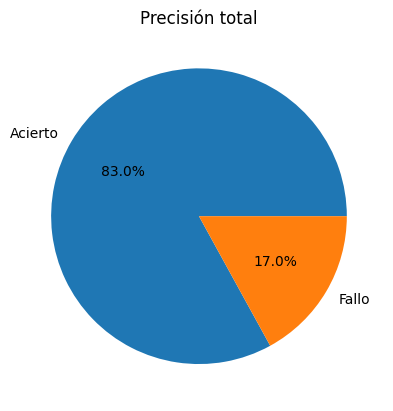

In [10]:
plt.pie([acc, 1-acc], labels=['Acierto', 'Fallo'], autopct='%1.1f%%')
plt.title('Precisión total')
plt.show()

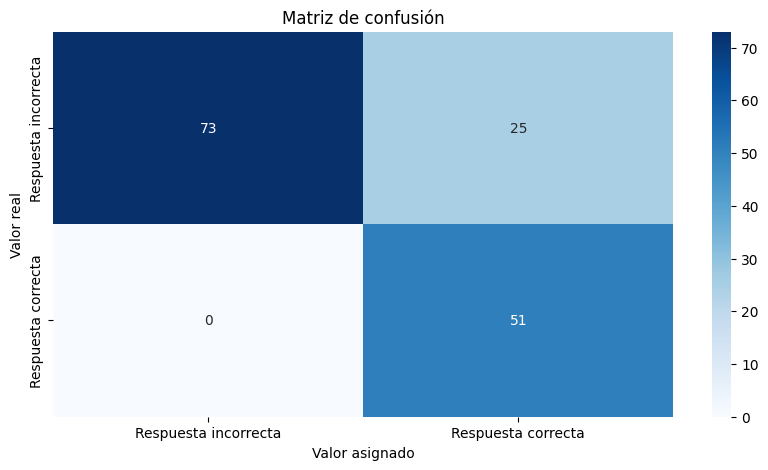

In [11]:
f,ax = plt.subplots(1,1,figsize=(10,5))
labels = ['Respuesta incorrecta', 'Respuesta correcta']
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues', fmt='g')
plt.xlabel("Valor asignado")
plt.ylabel("Valor real")
plt.title("Matriz de confusión")
plt.show()

In [10]:
crl = classification_report(y_true, y_pred)
print(crl)

              precision    recall  f1-score   support

       False       1.00      0.74      0.85        98
        True       0.67      1.00      0.80        51

    accuracy                           0.83       149
   macro avg       0.84      0.87      0.83       149
weighted avg       0.89      0.83      0.84       149



- **Precision**: La precisión es la proporción de instancias clasificadas como positivas que son realmente positivas. Para la clase False, la precisión es del 100%, lo que significa que todas las instancias clasificadas como False son realmente False. Para la clase True, la precisión es del 69%, lo que significa que el 69% de las instancias clasificadas como True son realmente True.

- **Recall**: El recall es la proporción de instancias positivas que fueron correctamente clasificadas como positivas. Para la clase False, el recall es del 77%, lo que significa que el 77% de las instancias True fueron correctamente clasificadas como True. Para la clase True, el recall es del 100%, lo que significa que todas las instancias True fueron correctamente clasificadas como True.

- **F1-score**: El F1-score es la media armónica de precision y recall. Es una medida única que combina tanto la precisión como el recall en una sola métrica. Cuanto mayor sea el F1-score, mejor será el rendimiento del modelo.

- **Accuracy**: La precisión general del modelo, que es la proporción de instancias clasificadas correctamente sobre el total de instancias.

- **Macro avg:** La media de precision, recall y F1-score para todas las clases. Es útil cuando las clases están desbalanceadas.

- **Weighted avg:** La media ponderada de precision, recall y F1-score para todas las clases, ponderadas por el soporte de cada clase. Es útil cuando hay un desequilibrio entre las clases.

En resumen, estas métricas indican que el modelo tiene un rendimiento perfecto en la clase False, con una alta precisión y un buen recall. Sin embargo, el rendimiento en la clase True es ligeramente menor, con una recall del 100% y una precisión del 69%. La precisión general del modelo es del 85%, lo que sugiere un buen rendimiento global.

## Análisis del prompt para validar una palabra y descripción proporcionada

In [12]:
def prompt_valid_desc(word, desc, theme):
	return f'Answer only "yes" or "no": is \'{word}\' described by \'{desc}\' and is the description or word related with {theme}?\n'

def system_prompt():
    return f'The description provided has to be related with the word and the theme, the description has to be clear, concise and enough information to guess the word'

def validate_questions(df, systemPrompt, function = prompt_valid_desc):
	correct = 0
	y_true = []
	y_pred = []

	for i in tqdm(range(len(df)),desc='Validating answers'):
		word = df.iloc[i]['word']
		desc = df.iloc[i]['definition']
		theme = df.iloc[i]['theme']
		prompt = function(word, desc, theme)
		if systemPrompt:
			mss = [{'role': 'system', 'content': system_prompt()}, {'role': 'user', 'content': prompt}]
		else:
			mss = [{'role': 'user', 'content': prompt}]
		response = client_openai.chat.completions.create(
			model=API_DIR,
			messages=mss,
			max_tokens=2,
			temperature=0.5
		)
		response = response.choices[0].message.content.replace(' ', '')
		y_true.append(True)
		if ('yes' in response.lower() and df.iloc[i]['valid'] == True) or ('no' in response.lower() and df.iloc[i]['valid'] == False):
			correct += 1
		if 'no' in response.lower():
			y_pred.append(False)	
		elif 'yes' in response.lower():
			y_pred.append(True)
		else:
			print(f"Error: {response}")
			y_pred.append(np.nan)
   
	return correct, y_true, y_pred

In [13]:
df = read_csv('../data/validation_prompts/questions.csv')

In [14]:
correct, y_true, y_pred = validate_questions(df, False)
correct_system, y_true_system, y_pred_system = validate_questions(df, True)

print(f"Correct answers: {correct}/{len(df)}")
print(f"Correct answers with system prompt: {correct_system}/{len(df)}")

Validating answers: 100%|██████████| 97/97 [00:45<00:00,  2.15it/s]

Correct answers: 91/97
Correct answers with system prompt: 88/97


Vemos que con un prompt de system no funciona mejor, así que probamos a cambiar el prompt de user

In [15]:
def prompt_valid_desc(word, desc, theme):
	return f'Answer only "yes" or "no": is this description \'{desc}\' valid to guess the word \'{word}\' and is the description or word related with {theme}?\n'

correct, y_true, y_pred = validate_questions(df, False)

print(f"Correct answers: {correct}/{len(df)}")

Validating answers: 100%|██████████| 97/97 [00:43<00:00,  2.23it/s]

Correct answers: 92/97


Este prompt no mejora el prompt anterior, así que seguimos con el prompt original

In [16]:
def prompt_valid_desc_theme(word, desc, theme):
	return f'Answer only "yes" or "no": is "{word}" and "{desc}" related to "{theme}"?'

def prompt_valid_desc_content(word, desc, theme):
	return f'Answer only "yes" or "no": is "{desc}" a valid description for "{word}"?'

correct, y_true, y_pred = validate_questions(df, False, prompt_valid_desc_theme)
correct, y_true, y_pred2 = validate_questions(df, False, prompt_valid_desc_content)

y_pred = [(y_pred[i] and y_pred2[i]) for i in range(len(y_pred))]
correct = sum(pred == true for pred, true in zip(y_pred, y_true))

print(f"Correct answers: {correct}/{len(df)}")

Validating answers: 100%|██████████| 97/97 [00:40<00:00,  2.38it/s]

Correct answers: 84/97


Mejora ligeramente la calidad de las respuestas

In [17]:
df['pred'] = y_pred
df[df['pred']!= df['valid']]

,word,definition,theme,valid,pred
24,Damascus,The capital city of Syria and one of the oldes...,Religion,True,False
47,Control,Refers to managing and regulating one's food i...,Weight loss,True,False
52,Brawl,A rough or noisy fight or quarrel,Boxing,False,True
75,Swirls,Decorative lines or shapes that are integrated...,Calligraphy,True,False
82,Candid,An adjective that describes a writing style in...,Autobiography,True,False
85,Houdini,Last name of the famous Hungarian-born America...,Mystery,False,True
89,Buried,"A hidden or concealed location, often containi...",Adventure,True,False
96,Ziggurat,A massive structure built in ancient Mesopotam...,Art history,False,True


In [18]:
def prompt_valid_desc_theme(word, desc, theme):
	return f'Answer only "yes" or "no": is "{word}" with this description "{desc}" related to "{theme}"?'

def prompt_valid_desc_format(word, desc, theme):
    return f'Answer only "yes" or "no": Is the description "{desc}" grammatically correct, logically coherent, and free of abrupt endings?'

def prompt_valid_desc_content(word, desc, theme):
    return f'Answer only "yes" or "no": Does the description "{desc}" provide enough information to accurately guess the word "{word}"?'

correct, y_true, y_pred1 = validate_questions(df, False, prompt_valid_desc_theme)
correct, y_true, y_pred2 = validate_questions(df, False, prompt_valid_desc_format)
correct, y_true, y_pred3 = validate_questions(df, False, prompt_valid_desc_content)

y_pred = [(y_pred1[i] and y_pred2[i] and y_pred3[i]) for i in range(len(y_pred))]
correct = sum(pred == true for pred, true in zip(y_pred, y_true))

print(f"Correct answers: {correct}/{len(df)}")

Validating answers: 100%|██████████| 97/97 [00:40<00:00,  2.38it/s]

Correct answers: 85/97


In [19]:
df['pred'] = y_pred
df[df['pred']!= df['valid']]

,word,definition,theme,valid,pred
24,Damascus,The capital city of Syria and one of the oldes...,Religion,True,False
52,Brawl,A rough or noisy fight or quarrel,Boxing,False,True
65,Vans,Brand known for its footwear and apparel in th...,Snowboarding,True,False
85,Houdini,Last name of the famous Hungarian-born America...,Mystery,False,True
89,Buried,"A hidden or concealed location, often containi...",Adventure,True,False
